# Problema

#### En la actualidad las redes neuronales son el unico modelo que existe para realizar aprendizaje profundo

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import sklearn
import itertools

# Clase auxiliar para procesar los datos

In [492]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        super().__init__()
        self.data = pd.read_csv(csv_file)
        self.len = self.data.shape[0]
    
    def __getitem__(self,index):
        x = self.data.iloc[index,1:-1].values.astype(dtype = 'float32')
        y = self.data.iloc[index,-1]
        x = torch.from_numpy(np.array(x)).type(torch.Tensor)
        y = torch.from_numpy(np.array([y])).type(torch.LongTensor)
        return index,x,y
        
    def __len__(self):
        return self.len

# Declaracion del modelo 

<img src="images/NN_Patrones (2).png"/>

In [493]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #self.fcl1 = torch.nn.Linear(5,6)
        self.fcl2 = torch.nn.Linear(5,2)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self,x):
        #x = self.sigmoid(self.fcl1(x))
        x = F.log_softmax(self.fcl2(x),dim=1)
        return x

# Procesamiento de los datos

In [494]:
batch_size = 100
valid_size = 0.2

dataset_train = CustomDataset("datasets/occupancy_data/datatraining.txt")
dataset_test = CustomDataset("datasets/occupancy_data/datatest.txt")

num_train = len(dataset_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx,valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset=dataset_train,batch_size=batch_size, sampler = train_sampler,num_workers=2)
eval_loader = DataLoader(dataset=dataset_train,batch_size=batch_size, sampler = valid_sampler,num_workers=2)
test_loader = DataLoader(dataset=dataset_test,batch_size=batch_size,num_workers=2)

# Resumen de los datos

In [495]:
dataset_train.data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


# Datos de ejemplo

In [496]:
dataset_train.data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


# Proceso de entrenamiento

### Instanciamos el modelo de la red, el optimizador y la funcion de error

In [497]:
model = Model()
optimizer = optim.SGD(model.parameters(),lr = 0.001, momentum=0.5)
criterion = torch.nn.NLLLoss()

### Declaramos la funcion para realizar el entrenamiento

In [498]:
def train(epochs,train,test):
    errors = np.zeros(shape=(epochs,2))
    min_eval_error = float("inf")
    for epoch in range(epochs):
        train_error = 0
        eval_error = 0
        accuracy = 0
        
        count = 0
        for index,x,y in train:
            optimizer.zero_grad()
            output = model(x)
            y = y.reshape(-1)
            error = criterion(output,y)
            error.backward()
            optimizer.step()
            train_error += error.item()
        
        with torch.no_grad():
            count = 0
            for index,x,y in test:
                output = model(x)
                y = y.reshape(-1)
                error = criterion(output,y)
                eval_error += error.item()
                inference = torch.exp(output)
                topp,topc = inference.topk(1,dim=1)
                equals = topc == y.view(*topc.shape)
                accuracy += torch.sum(equals.type(torch.FloatTensor))
                count += 100
            accuracy = accuracy/count
        errors[epoch]= [train_error,eval_error]
        
        if eval_error < min_eval_error :
            torch.save(model.state_dict(), 'model.pt')
            min_eval_error = eval_error
    return errors,min_eval_error,accuracy

### Ejecutamos la funcion de entrenamiento y obtenemos los errores de cada epoca, el minimo error y el accuracy

In [499]:
errors,min_eval_error,accuracy = train(10,train_loader,eval_loader)

### Graficamos los errores de entrenamiento y evaluacion

Error promedio en entrenamiento: 796.7515673398972
Error minimo en evaluacion: 28.808859318494797
Accuracy: 0.8482353091239929


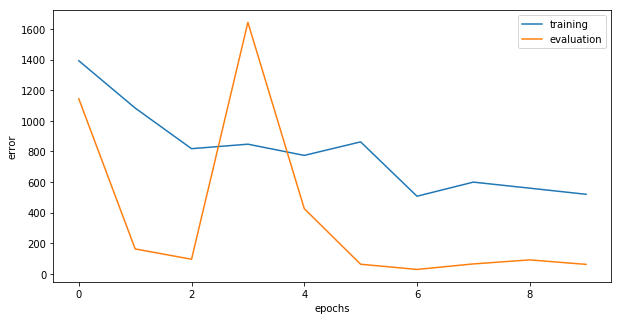

In [500]:
#print("Error promedio en entrenamiento: {}".format(errors[:,0].mean()))
#print("Error minimo en evaluacion: {}".format(min_eval_error))
#print("Accuracy: {}".format(accuracy))
plt.figure(figsize=(10,5))
plt.plot(errors[:,0],label="training")
plt.plot(errors[:,1],label="evaluation")
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend()
plt.show()

### Cargamos el modelo previamente guardado en la etapa de entrenamiento

In [501]:
model.load_state_dict(torch.load('model.pt', map_location=lambda storage, loc: storage))

### Mostramos la descripcion del dataset de pruebas

In [502]:
dataset_test.data.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


### Mostramos las primeras 5 filas del dataset de pruebas

In [503]:
dataset_test.data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


### Declaramos la funcion para probar nuestro modelo con el dataset de pruebas

In [504]:
def test(test):
    predictions = np.array([])
    true_class = np.array([])
    with torch.no_grad():
        for index,x,y in test:
            output = model(x)
            inference = torch.exp(output)
            topp,topc = inference.topk(1,dim=1)
            predictions = np.append(predictions, topc.numpy())
            true_class = np.append(true_class, y.reshape(-1))
    return predictions,true_class

### Ejecutamos la funcion para probar el dataset de pruebas con nuestro modelo entrenado

In [505]:
predictions,true_class = test(test_loader)

### Declaramos una funcion para graficar la matriz de confusion

In [506]:
def plotcm(cm):
    plt.title("Confusion Matrix")
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classes = np.arange(2)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Obtenemos y graficamos la matriz de confusion 

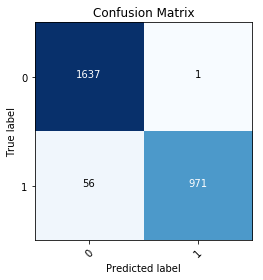

In [507]:
cm = sklearn.metrics.confusion_matrix(predictions,true_class)
plotcm(cm)

# Optimización empleando un automata celular

### Funcion para calcular la combinacion lineal de los pesos con los atributos

In [273]:
def linear(w,x):
    return np.dot(x,w.T)

### Declaracion de la clase Cell que contiene los pesos y la etiqueta

<img src="images/Automata_Patrones.png"/>

In [276]:
class Cell(object):
    def __init__(self):
        self.weights = []
        self.d = 0

### Declaracion del automata

In [484]:
class Automaton(object):
    def __init__(self,rows,cols,no_in,no_out,func):
        super().__init__()
        self.lattice = [[Cell() for j in range(cols)] for i in range(rows)]
        self.values = np.zeros(shape=(rows,cols))
        self.rows = rows
        self.cols = cols
        self.no_in = no_in
        self.no_out = no_out
        self.func = func
        self.mu = 0.4
        self.omega = 0.015
        self.maxVal = -float("inf")
        self.minVal = float("inf")
        self.errors = []
        self.minCoordinate = (0,0)
        
    def initialState(self,train):
        for i in range(self.rows):
            for j in range(self.cols):
                self.lattice[i][j].weights = np.random.rand(self.no_out,self.no_in)
        index,x,y = next(iter(train))
        self.updateAutomaton(x.numpy(),y.numpy())
        
    #moore neighborhood
    def moore(self):
        return [[-1,-1],[-1,0],[-1,1],
                [0,-1],[0,0],[0,1],
                [1,-1],[1,0],[1,1]]
    
    def validNeighbor(self,i,j,n):
        return ((i+n[0] >= 0 and i+n[0] < self.rows) and 
                (j+n[1] >= 0 and j+n[1] < self.cols))

    def getNeighbors(self,i,j):
        neighbors = []
        for n in self.moore():
            if self.validNeighbor(i,j,n):
                x = i+n[0]
                y = j+n[1]
                neighbors.append([x,y])
        return neighbors
    
    def findMax(self,values):
        maxVal = -float("inf")
        for i in range(len(values)):
            for j in range(len(values[i])):
                if values[i][j] > maxVal:
                    maxVal = values[i][j]
        return maxVal

    def findMin(self,values):
        coordinates = (0,0)
        minVal = float("inf")
        for i in range(len(values)):
            for j in range(len(values[i])):
                if values[i][j] < minVal:
                    coordinates = (i,j)
                    minVal = values[i][j]
        return coordinates,minVal
    
    def markingOut(self,i,j):
        cell = self.lattice[i][j]
        res = self.values[i][j]
        if (res-self.minVal)/(self.maxVal-self.minVal) <= self.mu:
            return 1
        else:
            return 0
        
    def markAll(self):
        for i in range(self.rows):
            for j in range(self.cols):
                self.lattice[i][j].d = self.markingOut(i,j)
                
    def refreshValues(self,x,y):
        for i in range(self.rows):
            for j in range(self.cols):
                self.values[i][j] = self.func(self.lattice[i][j].weights,x,y)
    
    def W(self,w1,w2):
        if ((w1 + 10 * self.omega) > w2
            and (w1 - 10 * self.omega) < w2):
            return 1
        else:
            return 0
    
    def avg(self,i,j,wr,wc):
        neighbors = self.getNeighbors(i,j)
        total = 0
        count = 0
        cell = self.lattice[i][j]
        for neigh in neighbors:
            r = neigh[0]
            c = neigh[1]
            cell2 = self.lattice[r][c]
            w = self.W(cell.weights[wr][wc],cell2.weights[wr][wc])
            total += cell2.d * w * cell.weights[wr][wc]
            count += cell2.d * w 
        return total / (count if count != 0 else 1)
            
    
    def evolutionRule1(self,i,j,x,y):
        cell = self.lattice[i][j]
        newWeights = cell.weights.copy()
        for r in range(len(cell.weights)):
            for c in range(len(cell.weights[r])):
                tempWeights = cell.weights.copy()
                tempWeights[r][c] = self.avg(i,j,r,c)
                newVal = self.func(tempWeights,x,y)
                if newVal < self.values[i][j]:
                    newWeights[r][c] = tempWeights[r][c]
        return newWeights
        
    def delta(self,i,j,wr,wc):
        cell = self.lattice[i][j]
        if cell.d == 0:
            r = math.pow(-1,random.randint(1,3))
            val = 0
            neighbors = self.getNeighbors(i,j)
            for n in neighbors:
                r = n[0]
                c = n[1]
                cell2 = self.lattice[r][c]
                val = val + math.pow(cell.weights[wr][wc] - cell2.weights[wr][wc],2)
            val = (1/(len(neighbors)-1))*val
            val = math.pow(val,1/2)
            return val
        else:
            return random.random()
    
    def evolutionRule2(self,i,j,x,y):
        cell = self.lattice[i][j]
        newWeights = cell.weights.copy()
        for r in range(len(cell.weights)):
            for c in range(len(cell.weights[r])):
                tempWeights = cell.weights.copy()
                tempWeights[r][c] = self.delta(i,j,r,c)
                newVal = self.func(tempWeights,x,y)
                if newVal < self.values[i][j]:
                    newWeights[r][c] = tempWeights[r][c]
        return newWeights
    
    def applyRule(self, rule,x,y):
        tempLattice = []
        for i in range(self.rows):
            row = []
            for j in range(self.cols):
                cell = Cell()
                cell.weights = rule(i,j,x,y)
                row.append(cell)
            tempLattice.append(row)
        return np.array(tempLattice)
    
    def updateAutomaton(self,x,y):
        self.refreshValues(x,y)
        self.maxVal = self.findMax(self.values)
        self.minCoordinate, self.minVal = self.findMin(self.values)
        self.markAll()
    
    def train(self,epochs,train):
        for epoch in range(epochs):
            error = 0
            for index,x,y in train:
                x = x.numpy()
                y = y.numpy()
                for it in range(3):
                    self.lattice = self.applyRule(self.evolutionRule1,x,y)
                    self.updateAutomaton(x,y)
                self.lattice = self.applyRule(self.evolutionRule2,x,y)
                self.updateAutomaton(x,y)
                error += self.minVal
            self.errors.append(error)
            
    def test2(self,test):
        p = np.array([])
        t = np.array([])
        accuracy = 0
        for index,x,y in test:
            i = self.minCoordinate[0]
            j = self.minCoordinate[1]
            cell = self.lattice[i][j]
            weights = cell.weights
            output = F.log_softmax(torch.from_numpy(linear(weights,x)),dim=1)
            inference = torch.exp(output)
            topp,topc = inference.topk(1,dim=1)
            equals = topc == y.view(*topc.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor))
            p = np.append(p, topc.numpy())
            t = np.append(t, y.reshape(-1))
        accuracy = accuracy / len(dataset_test.data)
        return p,t,accuracy
                    
                

### Declaramos la funcion de error

In [485]:
loss = torch.nn.NLLLoss()

### Declaramos la funcion que vamos a optimizar

In [486]:
def func1(w,x,y):
    with torch.no_grad():
        vl = torch.from_numpy(linear(w,x)).type(torch.Tensor)
        vl = F.log_softmax(vl,dim=1)
        target = y.reshape(-1)
        target = torch.from_numpy(target).type(torch.LongTensor)
        error = loss(vl,target)
    return error
    

In [487]:
layer1 = Automaton(3,3,5,2,func1)
layer1.initialState(train_loader)
layer1.train(2,train_loader)

### Graficamos el error de entrenamiento

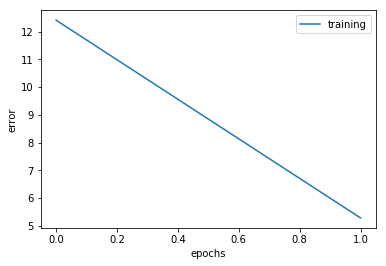

In [488]:
plt.plot(layer1.errors,label="training")
plt.xlabel("epochs")
plt.ylabel("error")
plt.legend()
plt.show()

### Probamos el modelo y graficamos la matriz de confusion

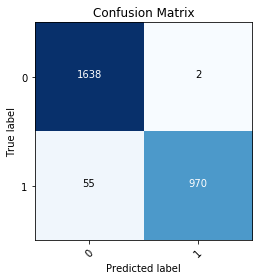

In [489]:
p,t,accuracy = layer1.test2(test_loader)
cm2 = sklearn.metrics.confusion_matrix(p,t)
plotcm(cm2)

In [491]:
print(accuracy*100)

tensor(97.8612)
